# Project Title - Team Quetelet

### Group Members:
#### Saraya Danielsen, Daysha Patalot, Maxwell Sapp (Manager), Hannah Thompson
Collaboration: We collaborated using the following tools:

Discord for out of class communication,

Google Docs for brief project brainstorming and research,

Github for project coding collaboration and data exploration.
 

### Project Abstract

Our team is using World Bank Data to explore population dynamics of North Korea over the 3 decade period of 1970 - 2000. We will explore a few significant events in areas such as economic policies and agricultural events that contributed to the observed dynamic explosive shifts of populations between rural and urban classes over this time period due to hard pushes of industrialized development. This large emphasis on industrialization pulled focus away from generating agricultural independence and proved that this industry was susceptible to failure when consecutive climate related events in the 1990s lead to national challenges of insufficient food production and widespread famine that resulted in 100s of thousands of lost lives and malnourished growth development. (Paraphrased general details for summary from wikipedia and Britannica links provided below, will add more specific quotes, numbers, and references into explanations below) 


* (can go into more detail after exploring and finishing out project on why we chose this subject, the general things we seeked to find out, etc, idk)


**link source**

#### Our project exploratory research goals included:
* Investigate when the urban population began substantially surpassing the rural population in 1970 in responses to the economic industrialization policies implemented through these decades. 
* How the nations population tripled during this time period, and how combinations of these factors led to food shortages and nationwide famine in the 1990s as a result of weather events and government policy.





In [5]:
# SOMETHING IN THIS CELL IS TOO MUCH MEMORY TO IMPORT; LET'S FIND OUT WHAT
# PROBABLY MATPLOTLIB OR PLOTLY??? That's the only thing different. I moved both to the cell below
#I think it's wbdata?

"""
If necessary, uncomment and install:
"""
# !pip install wbdata
# !pip install cufflinks


import wbdata
# import cufflinks as cf
import pandas as pd
import numpy as np



In [6]:
# leaving here because danger? run at ur own risk

import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
# THIS IS ERRORING

# from eep153_tools.sheets import read_sheets

# #### Read a bunch of google worksheets into a dictionary of dataframes
# data = read_sheets('https://docs.google.com/spreadsheets/d/1DLn9owcS7ggojJGWlI9vKSz0hqozn6cbcqNGWgzMZ8k',force_numeric=False)

# data.keys()

## [A] Population Statistic Function

It's a long function, but it is incredibly specifc; you can estimate any combination of ages, including a single age. It can do much more than just capture the already-established bins. It creates corresponding ratios when an age lands somewhere in the middle of a bin.

###### `population()`


In [4]:
def population(country, year, sex, lower_age, upper_age):
    '''Function returns a SINGLE computed statistic given all the variables.'''
    # 'sex' inputs as either 'All' (for 'All people'), or 'Male' or 'Female'
    
    def build_year_labelled_df(variable_labels, year, country):
        '''Creates a dataframe with 1 or multiple needed labels, so that it can be called in a variety of situations below.'''
        df = wbdata.get_dataframe(variable_labels)
        df = wbdata.get_dataframe(variable_labels, country=country)
        df.reset_index(inplace=True)
        df['date'] = df['date'].astype(int)
        df.set_index(['date'], inplace=True)
        df_with_year = df.query('date==@year')
        return df_with_year
    
    
    variable_labels = {}
    
    # Edge case: not working with age bins, just total population or total male/female population (which have different labels than age bins)
    if lower_age==0 and upper_age>=80:
        if sex=="All":
            variable_labels["SP.POP.TOTL"] = "Total Population"
        elif sex=="Male":
            variable_labels["SP.POP.TOTL.MA.IN"] = "Total Male Population"
        elif sex=="Female":
            variable_labels["SP.POP.TOTL.FE.IN"] = "Total Female Population"
        return build_year_labelled_df(variable_labels, year=year, country=country)[list(variable_labels.values())[0]].iloc[0]
    
    
    # Everything below works with age bins 
    
    # First round up/round down the age boundaries so that all necessary bins will be included
    # (The fraction will be multiplied to get a corresponding smaller ratio of an age-bracket population)
    lower_age_rounded = lower_age
    lower_fraction = 0
    if lower_age%5 != 0:
        if lower_age%5 == 4:
            lower_age_rounded = lower_age - 4
            lower_fraction = (1/5)
        elif lower_age%5 == 3:
            lower_age_rounded = lower_age - 3
            lower_fraction = (2/5)
        elif lower_age%5 == 2:
            lower_age_rounded = lower_age - 2
            lower_fraction = (3/5)
        elif lower_age%5 == 1:
            lower_age_rounded = lower_age - 1
            lower_fraction = (4/5)
    upper_age_rounded = upper_age
    upper_fraction = 0
    if upper_age%5 != 4:
        if upper_age%5 == 3:
            upper_age_rounded = upper_age + 1
            upper_fraction = (4/5)
        elif upper_age%5 == 2:
            upper_age_rounded = upper_age + 2
            upper_fraction = (3/5)
        elif upper_age%5 == 1:
            upper_age_rounded = upper_age + 3
            upper_fraction = (2/5)
        elif upper_age%5 == 0:
            upper_age_rounded = upper_age + 4
            upper_fraction = (1/5)
    
    
    # Get the labels ONLY for the bins that YOU NEED, using a loop that adds to a dictionary as you go
    placehold = lower_age_rounded
    
    def digit_adjust(placehold):
        '''Function that will prepare ages to be used to make variable_labels; turns an int to a string, and reformats single-digit numbers.'''
        if placehold < 10:
            return str(0)+str(placehold)
        else:
            return str(placehold)
    
    while placehold <= upper_age_rounded:
        while placehold < 80:
            if sex=="All":
                variable_labels["SP.POP."+digit_adjust(placehold)+digit_adjust(placehold+4)+".MA"] = str(placehold)+"-"+str(placehold+4)+" Male"
                variable_labels["SP.POP."+digit_adjust(placehold)+digit_adjust(placehold+4)+".FE"] = str(placehold)+"-"+str(placehold+4)+" Female"
            elif sex=="Male":
                variable_labels["SP.POP."+digit_adjust(placehold)+digit_adjust(placehold+4)+".MA"] = str(placehold)+"-"+str(placehold+4)+" "+sex
            elif sex=="Female":
                variable_labels["SP.POP."+digit_adjust(placehold)+digit_adjust(placehold+4)+".FE"] = str(placehold)+"-"+str(placehold+4)+" "+sex
            placehold += 5
            
            if placehold >= 80:
                if sex=="All":
                    variable_labels["SP.POP.80UP.MA"] = "80+ Male"
                    variable_labels["SP.POP.80UP.FE"] = "80+ Female"
                elif sex=="Male":
                    variable_labels["SP.POP.80UP.MA"] = "80+ Male"
                elif sex=="Female":
                    variable_labels["SP.POP.80UP.FE"] = "80+ Female"
            break
            
            
    # Now you have a 'variable_labels' that is filled with every label you need; compute final calculations:
    final_df = build_year_labelled_df(variable_labels, year=year, country=country)
    bin_count = len(list(variable_labels.keys()))
    added = 0
    i = 0
    
    
    # Edge case: if you're working with LESS THAN ONE AGE BIN
    # (1) For when the ages are different, but smaller than a single age bin (ex: 3-4 year olds)
    age_difference = upper_age - lower_age
    if age_difference<4 and bin_count==2 and sex=='All': 
        fraction = (age_difference + 1)/5
        while i < bin_count:
            added += (fraction*final_df.iloc[:, i].tolist()[0])
            i+=1
    if age_difference<4 and bin_count==1 and (sex=='Male' or sex=='Female'): 
        fraction = (age_difference + 1)/5
        return np.round(fraction * final_df.iloc[:, 0].tolist()[0])
    
    # (2) For when you're working with a single age (ex: 3-year-olds)
    if lower_age == upper_age:
        fraction = (1/5)
        if sex=="All":
            while i < 2:
                added += (fraction*final_df.iloc[:, i].tolist()[0])
                i+=1
        else:
            return np.round(fraction * final_df.sum(axis=1).tolist()[0])
    
    
    
    # FINAL OUTPUTS FOR 1 OR MORE AGE BINS: (4 different variations of cases)
    
    # CASE 1: If no rounding was needed (perfect bins):
    if lower_age%5==0 and upper_age%5==4:
        return final_df.sum(axis=1).tolist()[0]
        
        
    # CASE 2: If lower_age was rounded and upper_age wasn't:
    elif lower_age%5!=0 and upper_age%5==4:
        # For sex="All", TWO COLUMNS will need to be adjusted (Male AND Female)
        if sex=="All":
            while i < bin_count:
                while i < 2:
                    added += (lower_fraction*final_df.iloc[:, i].tolist()[0])
                    i+=1
                added += final_df.iloc[:, i].tolist()[0]
                i+=1
        else:
            while i < bin_count:
                while i < 1:
                    added += (lower_fraction*final_df.iloc[:, i].tolist()[0])
                    i+=1
                added += final_df.iloc[:, i].tolist()[0]
                i+=1
            
    
    # CASE 3: If upper_age was rounded and lower_age wasn't:
    elif lower_age%5==0 and upper_age%5!=4:
        if sex=="All":
            while i < bin_count:
                while i < (bin_count - 2):
                    added += final_df.iloc[:, i].tolist()[0]
                    i+=1
                added += (upper_fraction*final_df.iloc[:, i].tolist()[0])
                i+=1
            return np.round(added)
        else:
            while i < bin_count:
                while i < (bin_count - 1):
                    added += final_df.iloc[:, i].tolist()[0]
                    i+=1
                added += (upper_fraction*final_df.iloc[:, i].tolist()[0])
                i+=1
        
            
    # CASE 4: If both upper_age and lower_age were rounded:
    else:
        if sex=="All":
            while i < bin_count:
                while i < 2:
                    added += (lower_fraction*final_df.iloc[:, i].tolist()[0])
                    i+=1
                while i>1 and i<(bin_count - 2):
                    added += final_df.iloc[:, i].tolist()[0]
                    i+=1
                added += (upper_fraction*final_df.iloc[:, i].tolist()[0])
                i+=1
        else:
            while i < bin_count:
                while i < 1:
                    added += (lower_fraction*final_df.iloc[:, i].tolist()[0])
                    i+=1
                while i>0 and i<(bin_count - 1):
                    added += final_df.iloc[:, i].tolist()[0]
                    i+=1
                added += (upper_fraction*final_df.iloc[:, i].tolist()[0])
                i+=1 
                
                
    return np.round(added)
                

#### Test cases for population statistic function:

In [5]:
# Should be False
population("WLD", 2000, "Male", 0, 100) > 7e9

False

In [6]:
# Should be True
population("USA", 1993, "Female", 66, 73, ) == 8269864.0
population("USA", 1993, "All", 3, 11) == 34293840.0
population("USA", 1993, "All", 3, 3) == 3976670.0
population("USA", 1993, "Female", 3, 4) == 3886545.0
population("USA", 1993, "All", 3, 4) == 7953340.0
population("USA", 1993, "All", 5, 6) == 7621651.0

True

## [A] Population Dataframes Function 

**age_sex_df()** returns a data frame indexed by country and year populated with counts of total population in certain age/sex categories. Inputs include year and country so that one can obtain desired counts for specific parameters. The function can take strings or list of strings for each parameter.

###### `age_sex_df()`


In [7]:
def age_sex_df(country='all', year='all'):
   
    # create list of age ranges for population counts
    age_ranges = []
    for i in range(0, 80, 5):        
        age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
    age_ranges.append('80UP') #adds 80 and up

    
    # create dictionary all_indicators of all age-sex indicators from wbdata 
    male_age_indicators = {'SP.POP.'+ages+'.MA':'Males '+ages for ages in age_ranges}
    female_age_indicators = {'SP.POP.'+ages+'.FE':'Females '+ages for ages in age_ranges}
    all_indicators = male_age_indicators 
    all_indicators.update(female_age_indicators) 
    
  
    # create dataframe with all_indicators as columns 
    final_df = wbdata.api.get_dataframe(all_indicators, country='all', data_date=None, freq='Y', source=None, convert_date=False, keep_levels=False, cache=True)
    

    # if no country input, save all regions' data, else only data for country
    if country == 'all':
        final_df = final_df
    else:
        if isinstance(country, list):
            final_df = final_df.loc[pd.Index(country)]
        else:
            final_df = final_df.loc[pd.Index([country])]
    
        
    #setting row data as integers rather than floats 
    final_df.fillna(0, inplace=True)
    final_df = final_df.astype(int)
    
    
    # if year is specified, return only year indices
    if year =='all':
        return final_df
    else:
        return final_df.loc[pd.IndexSlice[:, year], :]


**Test Cases for population dataframes function:**

In [8]:
# uncomment and try inputs for one country and one year
# age_sex_df("Korea, Dem. People's Rep.", '1970')
# uncomment and try function for multiple countries and years
# age_sex_df(["Korea, Dem. People's Rep.", 'Korea, Rep.'], ['1970', '1990'])

age_sex_df()

Males 0004  Males 0509  Males 1014  \
country                     date                                       
Africa Eastern and Southern 2021           0           0           0   
                            2020    51832999    47054442    42100652   
                            2019    51064807    46254023    41098615   
                            2018    50313865    45400780    40053419   
                            2017    49562847    44486999    38997474   
...                                      ...         ...         ...   
Zimbabwe                    1964      425511      341934      272226   
                            1963      406613      334139      253308   
                            1962      388512      324521      234396   
                            1961      374911      310962      218241   
                            1960      367183      293471      206053   

                                  Males 1519  Males 2024  Males 2529  \
country                     date                                       
Africa Eastern and Southern 2021           0           0           0   
                            2020    36604829    31449112    26714656   
                            2019    35608673    30568938    25964678   
                            2018    34646945    29711246    25240682   
                            2017    33721493    28879258    24536591   
...                                      ...         ...         ...   
Zimbabwe                    1964      194836      180409      145314   
                            1963      192015      174959      141255   
                            1962      192241      168481      137769   
                            1961      192190      161950      134425   
                            1960      189731      156032      130976   

                                  Males 3034  Males 3539  Males 4044  \
country                     date                                       
Africa Eastern and Southern 2021           0           0           0   
                            2020    22601024    18778125    15094710   
                            2019    21933394    18132172    14566690   
                            2018    21276921    17483365    14080376   
                            2017    20629605    16845283    13624471   
...                                      ...         ...         ...   
Zimbabwe                    1964      122831      104894       86161   
                            1963      120608      101291       86143   
                            1962      118598       97612       86675   
                            1961      116218       94407       86629   
                            1960      113128       92026       85291   

                                  Males 4549  ...  Females 3539  Females 4044  \
country                     date              ...                               
Africa Eastern and Southern 2021           0  ...             0             0   
                            2020    12163439  ...      19420963      15669437   
                            2019    11720436  ...      18759569      15100033   
                            2018    11277635  ...      18080584      14571653   
                            2017    10844283  ...      17401444      14076312   
...                                      ...  ...           ...           ...   
Zimbabwe                    1964       78264  ...        106990         87773   
                            1963       75205  ...        103182         87655   
                            1962       71553  ...         99235         88122   
                            1961       67947  ...         95751         87970   
                            1960       64830  ...         93114         86458   

                                  Females 4549  Females 5054  Females 5559  \
country                     date                                             
Africa Easter

## [B] Population Pyramids

**A study of North Korea's population in the 1990s.**


#### (B) Population Pyramids Deliverable Instructions:
A python function that takes as input a pandas DataFrame with columns providing counts of people by age-sex groups, and constructs a “population pyramid” graph for visualizing the data.

Can we add in visual notes of when events happened? Directly onto the graph

In [9]:
wbdata.get_country('PRK')

id    name
----  -------------------------
PRK   Korea, Dem. People's Rep.

In [8]:
age_ranges = []
for i in range(0, 80, 5):        
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
age_ranges.append('80UP') #adds 80 and up
age_ranges.reverse()

In [9]:
nk = age_sex_df("Korea, Dem. People's Rep.", '1993')
nk

,,Males 0004,Males 0509,Males 1014,Males 1519,Males 2024,Males 2529,Males 3034,Males 3539,Males 4044,Males 4549,...,Females 3539,Females 4044,Females 4549,Females 5054,Females 5559,Females 6064,Females 6569,Females 7074,Females 7579,Females 80UP
country,date,,,,,,,,,,,,,,,,,,,,,
"Korea, Dem. People's Rep.",1993,1015270,1005632,896771,960831,1241781,1042572,849226,715955,448954,622157,...,725771,483282,663505,631517,531297,384749,287255,201340,123545,100893


In [10]:
import seaborn as sns

[Text(0.5, 0, 'Population (hundreds of millions)'),
 Text(0, 0.5, 'Age-Group'),
 Text(0.5, 1.0, 'Population Pyramid')]

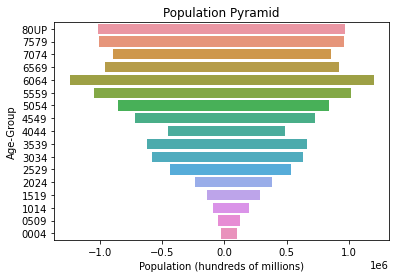

In [11]:
male = nk.iloc[:, :17].values[0]*-1
female = nk.iloc[:, 17:].values[0]


bar_plot = sns.barplot(x=male, y=age_ranges, data=nk, order=age_ranges)

bar_plot = sns.barplot(x=female, y=age_ranges, data=nk, order=age_ranges)

bar_plot.set(xlabel="Population (hundreds of millions)", ylabel="Age-Group", title = "Population Pyramid")

## Research Exploration: North Korean 1990s Famine: 1993, 2000

Since self-sufficiency remains an important pillar of North Korean ideology, self-sufficiency in food production is deemed a worthy goal. Another aim of government policies—to reduce the gap between urban and rural living standards—requires continued investment in the agricultural sector. The stability of the country depends on steady, if not rapid, increases in the availability of food items at reasonable prices. In the early 1990s, there were severe food shortages.[19][90][91]

The most far-reaching statement on agricultural policy is embodied in Kim Il-sung's 1964 Theses on the Socialist Agrarian Question in Our Country, which underscores the government's concern for agricultural development.[92] Kim emphasized technological and educational progress in the countryside as well as collective forms of ownership and management. As industrialization progressed, the share of agriculture, forestry, and fisheries in the total national output declined from 63.5% and 31.4%, respectively, in 1945 and 1946, to a low of 26.8% in 1990. Their share in the labor force also declined from 57.6% in 1960 to 34.4% in 1989.[19]

In the 1990s, the decreasing ability to carry out mechanized operations (including the pumping of water for irrigation), as well as lack of chemical inputs, was clearly contributing to reduced yields and increased harvesting and post-harvest losses.[84]

The food shortage was primarily precipitated by the loss of fuel and other raw materials imports from China and the Soviet Union which had been essential to support an energy intensive and energy inefficient farming system. Following the collapse of the Soviet Union, the former concessional trade relationships which benefited the North Korea were not available. The three flood and drought years between 1994 and 1996 only served to complete the collapse of the agriculture sector.[90][96][97] In 2004, more than half (57%) of the population did not have enough food to stay healthy. 37% of children had their growth stunted and 1⁄3 of mothers severely lacked nutrition.[98]

In [ ]:
# 1993, 2000 Population Pyramid here

## Experimental Data Exploration and Choosing Topic

Using plotly.express, we take a closer look at urban and rural population trends in North Korea from the span on 1960 to 2020.

In [ ]:
# Give variable for clarity - urban vs rural population growth rate
variable_labels = {'SP.URB.GROW' : 'upg', 'SP.RUR.TOTL.ZG': 'rpg'}

prk_pop_grow = wbdata.get_dataframe(variable_labels, country='PRK')
prk_pop_grow

In [ ]:
# Can we add in visual notes of when events happened? Directly onto the graph
#plotting North Korean urban population growth vs rural population growth from 1960-2020
fig = px.line(prk_pop_grow, x=prk_pop_grow.index, y=['upg', 'rpg'])
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show()

Growth rates of the urban and rural populations in North Korea are nearly equivalent during the late 1970s. What might be the cause? Before 1976, growth rates appear to mirror each other in the opposite directions. What socioeconomic events would cause the rural population to fall while the urban population increases? 

In [ ]:
# Give variable for clarity - urban vs rural population total
variable_labels = {'SP.URB.TOTL' : 'urban pop', 'SP.RUR.TOTL': 'rural pop'}

world_pop_urban_rural = wbdata.get_dataframe(variable_labels, country="WLD")
prk_pop_urban_rural = wbdata.get_dataframe(variable_labels, country='PRK')
prk_pop_urban_rural

In [ ]:
#plotting North Korean urban population total vs rural population total from 1960-2020
fig = px.line(prk_pop_urban_rural, x=prk_pop_urban_rural.index, y=['urban pop', 'rural pop'])
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show()

The total population of North Korean urban areas surpasses that of rural areas in 1969. From 1969 onwards, the urban population takes on an approximately linear trend. On the other hand, the rural population first experiences a negative trend and then a positive trend until the year 2000 when it stabilizes.

### More on 90's Famine

In [ ]:
# this doesn't work yet—deal with that

def get_international_ag_productivity_data(series):

    columns=series.iloc[1,:]  # Need to fix columns
    series = series.iloc[2:,:]
    series.columns = columns

    # Set index to country code
    series = series.set_index('WDI Code')

    series = series[['%d' % t for t in range(1961,2020)]]

    series = series.replace({',':''},regex=True) # Get rid of commas in number strings
    series = series.replace({'':'NaN'}) # Change empty cells to NaN strings
    series = series.apply(lambda x: pd.to_numeric(x,errors='ignore'))
    series = series.astype(float) # Convert to floats

    series = series.stack()
    
    series = series.loc[~series.index.duplicated(keep='first')] 

    series.index.names = ['WDI Code','Year']

    return series
   

Data = ['Output','Ag TFP','Ag Land','Irrig','Pasture','Labor','Livestock',
        'Machinery','Fertilizer','Feed']

D = {}
for key in Data:
    D[key] = get_international_ag_productivity_data(data[key])

df = pd.DataFrame(D)


PRK = df.xs('PRK',level='WDI Code').dropna(how='any')

select = np.log(PRK)
select.iplot(title='Log North Korea inputs & output')

## Summary Conclusion

(After all our investigation, here's the place to show how interconnected the events are—paint a picture of how they flow chronologically and have affected North Korea. Use this space to do so)
* Add in economic and agricultural context that's relevant to the class